# Introduction
This colab worksheet provides a starting point for the computer vision assignment.

# Data Loading

In [1]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo" -O training_images.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/i0apaktucm7y4od7k4ux69k8t1iue7w8" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/aulkv3tf2fc0765yqgfm9am87vgn3p8a" -O examples.npz



--2024-05-15 11:06:12--  https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-15 11:06:12--  https://sussex.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-15 11:06:12--  https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://euc1.b

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [2]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'cf2a926d2165322adcd19d2e88b2eb1cd200ea5c')
confirm_checksum('examples.npz', '0fadc9226e4c0efb4479c5c1bf79491d75828ad3')
confirm_checksum('test_images.npz', 'c7b4b297c7e5c5009706f893ad1fb77a2aa73f95')



# Load the data

In [3]:
import numpy as np


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
train_images = data['images']
# and the data points
train_pts = data['points']

print(train_images.shape, train_pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(2811, 256, 256, 3) (2811, 44, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


# Data Visualisation
Here's an example of how to display the images and their points

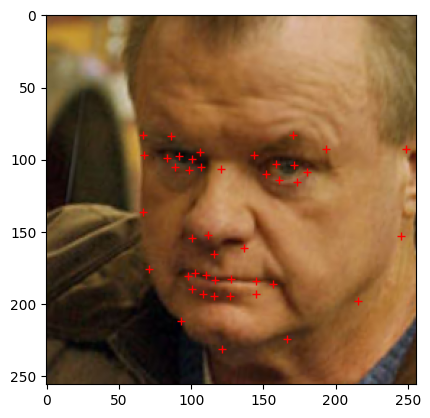

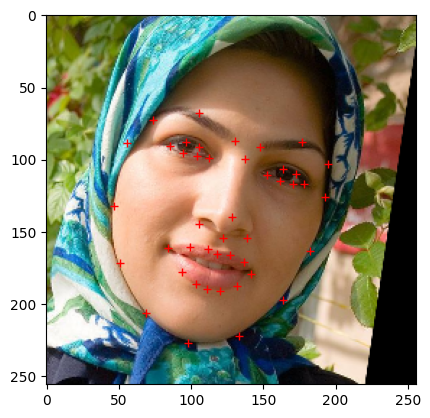

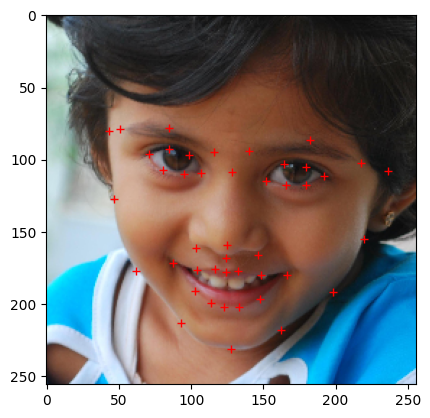

In [4]:

def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, train_images.shape[0])
  visualise_pts(train_images[idx, ...], train_pts[idx, ...])

# Image Preprocessing

In [5]:
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d

def preprocess(images):
  """
  Perform necessary preprocessing for each image in the array
  :param images: Array of images
  :return: NumPy array of preprocessed images
  """
  imgs = []
  for idx in range(images.shape[0]):
    gray_img = np.uint8(np.mean(images[idx], axis=-1)) # Convert to grayscale
    eq_img = cv2.equalizeHist(gray_img) # Histogram Equalize the grayscale image
    blurred =  cv2.GaussianBlur(eq_img,(5,5),3) # Gaussian Noise Reduction
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    edge_image = cv2.addWeighted(cv2.convertScaleAbs(sobelx), 1, cv2.convertScaleAbs(sobely), 1, 0)
    imgs.append(edge_image)
  return np.array(imgs)

def preprocess_image(image):
    gray_img = np.uint8(np.mean(image, axis=-1)) # Convert to grayscale
    eq_img = cv2.equalizeHist(gray_img) # Histogram Equalize the grayscale image
    blurred =  cv2.GaussianBlur(eq_img,(5,5),3) # Gaussian Noise Reduction
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    edge_image = cv2.addWeighted(cv2.convertScaleAbs(sobelx), 1, cv2.convertScaleAbs(sobely), 1, 0)
    return edge_image

In [6]:
from sklearn.model_selection import train_test_split

# Preprocess Training images and store them in train_imgs
train_imgs = preprocess(train_images)

# Preprocess Testing Images and store them in test_imgs
test_imgs = preprocess(test_images)

# Preprocess Qualitative data images and store them in example_imgs
example_imgs = preprocess(example_images)

# Split training images and points into training and test data
# Test data with ground truth points will help in testing the performance and accuracy of the model
X_train, X_test, y_train, y_test = train_test_split(train_imgs, train_pts, test_size=0.2, random_state=42)

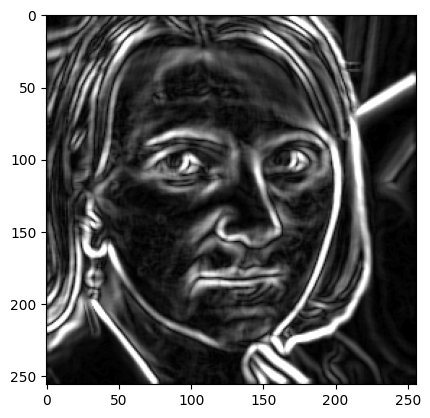

In [7]:
plt.imshow(X_train[1], cmap="gray")

Feature extraction algorithm

In [8]:
# Import necessary libraries

import numpy as np
from skimage.feature import hog
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


In [9]:
# Less performed version of HoG feature extraction that reads features just around landmarks


def extract_hog_features_around_landmarks(images, landmarks, window_size=120, pixels_per_cell=(60, 60), cells_per_block=(2, 2), orientations=9):
    features = []  # list of features per image

    for img, lmks in zip(images, landmarks):
        img_features = []  # Image features
        for x,y in lmks:   # Single landmark
            # Define the Region of Interest (ROI) around current landmark
            # by defining a square window of size (winow_size x window_size)
            x1 = int(max(x - window_size / 2, 0))  # If x1 less than 0 - set to zero
            y1 = int(max(y - window_size / 2, 0))  # If y2 less than 0 - set to zero
            x2 = int(min(x + window_size / 2, img.shape[1]))  # If x2 larger than image resolution - set to image resolution
            y2 = int(min(y + window_size / 2, img.shape[0]))  # If y2 larger than image resolution - set to image resolution


            # Covering edge cases to adjust window size
            if (x2 - x1) < (pixels_per_cell[0] * cells_per_block[0]):
              x2 += window_size - (x2 - x1)
              if x2 > img.shape[1]:
                x1 -= x2 - img.shape[1]
                x2 -= x2 - img.shape[1]
            elif (y2 - y1) < (pixels_per_cell[1] * cells_per_block[1]):
              y2 += window_size - (y2 - y1)
              if y2 > img.shape[0]:
                y1 -= y2 - img.shape[0]
                y2 -= y2 - img.shape[0]

            # Define Region of Interest
            roi = img[y1:y2, x1:x2]

            # Extract HOG features from the ROI
            roi_feature = hog(roi, orientations=orientations, pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block, block_norm='L2')
            # Add features of a single landmark to image features array
            img_features.extend(roi_feature)

        # Add Image features to array
        features.append(img_features)

    return np.array(features)

In [10]:
# Histogram of Oriented Gradients (HoG) Feature Extraction Algorithm that extracts features from array of images

def extract_hog_features(images, pixels_per_cell=(20, 20), cells_per_block=(4, 4), orientations=15):
  """
    Extract HoG features from each image

    :param images: List or array of preprocessed images.
    :param pixels_per_cell: Define size of the cell as HoG divides the image on the cells
    :param cells_per_block: Define number of cells per block
    :return: a list of fatures for each image [num_of_images, num_of_features].
    """

  # List of features
  features = []

  # For each image add a list of features
  for img in images:
    img_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm='L2')
    features.append(img_features)

  return features

In [11]:
def extract_sobel_features(images, ksize=3):
    """
    Extract gradient features using the Sobel operator

    :param images: array of preprocessed images
    :param ksize: size of the kernel
    :return: np.array: Array of feature vectors for each image.
    """
    features = []

    for img in images:
        # Compute the x and y gradients using the Sobel operator
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)

        # Compute the gradient magnitude and direction
        magnitude = cv2.magnitude(grad_x, grad_y)
        angle = cv2.phase(grad_x, grad_y, angleInDegrees=True)

        # Flatten the magnitude and angle matrices to create a feature vector
        feature_vector = np.hstack((magnitude.flatten(), angle.flatten()))

        # Add to the list of features
        features.append(feature_vector)

    return np.array(features)

Training SDM model

In [12]:
from sklearn.multioutput import MultiOutputRegressor
def train_sdm(images, ground_truth_landmarks, num_iterations=4, alpha = 1.0):
    """
    Train SDM with Linear Regression.

    :param images: List or array of preprocessed images
    :param ground_truth_landmarks: Ground truth landmark positions
    :param num_iterations: Number of iterations for the SDM training.
    :param alpha: Regularisation factor for Ridge Regression
    :return: A list of trained Linear Regression models.
    """

    models = []  # list of models

    # Create initial guess landmarks and format it to the right shape
    initial_landmarks = np.mean(ground_truth_landmarks, axis=0)  # Mean mask
    current_landmarks = np.copy(initial_landmarks)
    n_samples = ground_truth_landmarks.shape[0]
    current_landmarks = np.tile(current_landmarks[None, :, :], (n_samples, 1, 1)) # Add dimensionality

    # extract features from each image
    features = extract_hog_features(images)
    #features = extract_sobel_features(images)

    for iteration in range(num_iterations):
        print(f"Iteration: {iteration + 1}")

        # Calculate delta landmarks, distances between each point from ground truth landmarks and current landmarks
        delta_landmarks = ground_truth_landmarks - current_landmarks
        delta_landmarks = delta_landmarks.reshape(delta_landmarks.shape[0], -1)  # adjust the shape

        # Train the Regression

        #model = LinearRegression()  # Linear Regression

        model = Ridge(alpha=alpha)  # Ridge Regression

        # Support Vector Regression

        #scaler_X = StandardScaler()
        #scaler_y = StandardScaler()
        #features = scaler_X.fit_transform(features)
        #delta_landmarks = scaler_y.fit_transform(delta_landmarks.reshape(-1, 1)).ravel()
        #model = MultiOutputRegressor(SVR(kernel='rbf', C=1.0, epsilon=0.1))

        model.fit(features, delta_landmarks)  # Fit model

        # Predict updates and apply them to update the landmark positions
        updates = model.predict(features)
        current_landmarks += updates.reshape(current_landmarks.shape)

        # Add trained model to the list
        models.append(model)

    return models

Run the cell below to train the model

In [13]:
# Generate a list of trained models on training images and true points
models = train_sdm(train_imgs, train_pts, alpha=400)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [14]:
models = train_sdm(X_train, y_train, alpha=400)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


SDM Predict Function

In [15]:
def sdm_predict(new_image, initial_landmarks, models):
    """
    Apply the trained SDM models to predict facial landmarks on a new image.

    :param new_image: The new image to predict landmarks on
    :param initial_landmarks: The initial guess for the landmarks
    :param models: A list of trained regressor models from the SDM training phase.
    :return: The predicted landmark positions, shape (n_landmarks, 2).
    """

    current_landmarks = np.copy(initial_landmarks)


    # Sequentially apply each model
    for model in models:
        # Extract HOG features from new image
        features = extract_hog_features(new_image)
        #features = extract_sobel_features(new_image)
        features = np.array(features)

        # Predict updates using the current model
        updates = model.predict(features)

        # Update the current landmarks with the predicted changes
        current_landmarks += updates.reshape(current_landmarks.shape)

    return current_landmarks

Predict and display predicted landmarks on example images

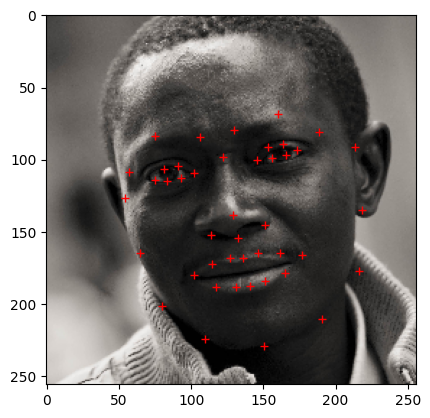

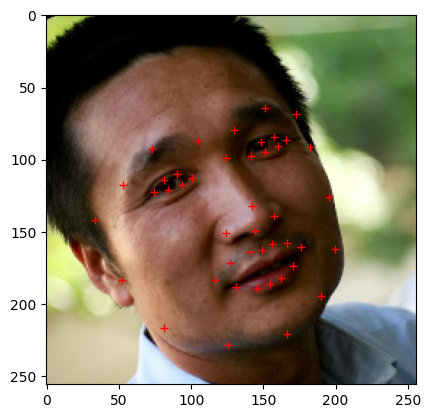

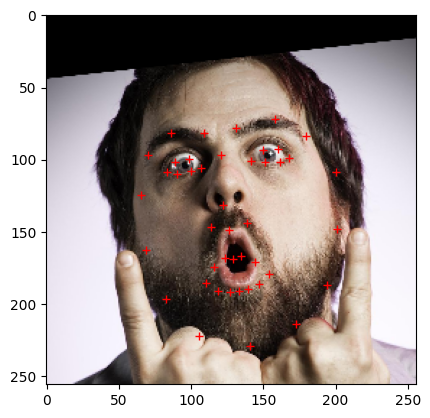

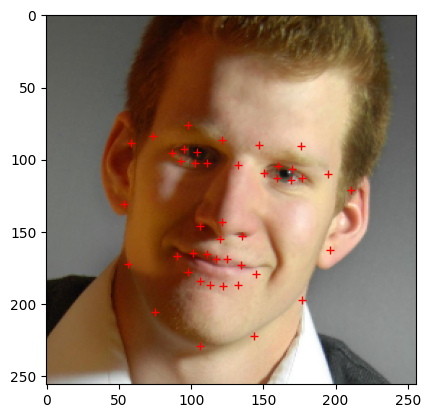

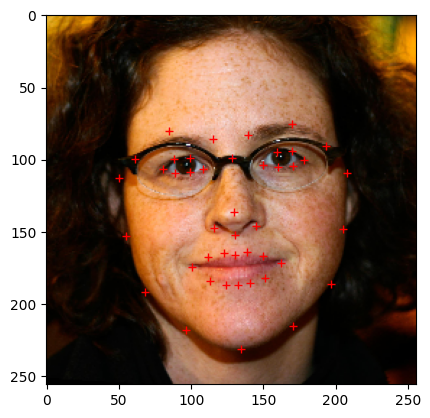

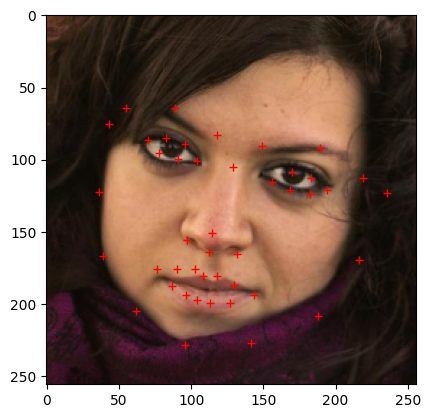

In [16]:
# Initial landmarks
initial_landmarks = np.mean(train_pts, axis=0)
initial_landmarks = initial_landmarks.reshape(1,44,2)

#Example Imges on qualitative data
for i in range(len(example_imgs)):
  test_img = example_imgs[i].reshape(1,256,256)
  landmarks = sdm_predict(test_img, initial_landmarks, models)
  landmarks = landmarks.reshape(44,2)
  visualise_pts(example_images[i], landmarks)

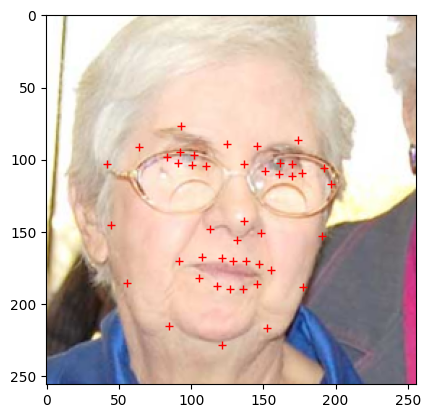

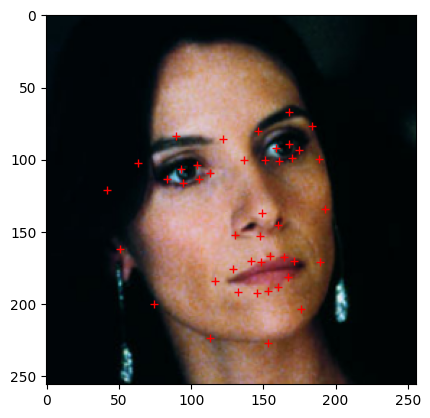

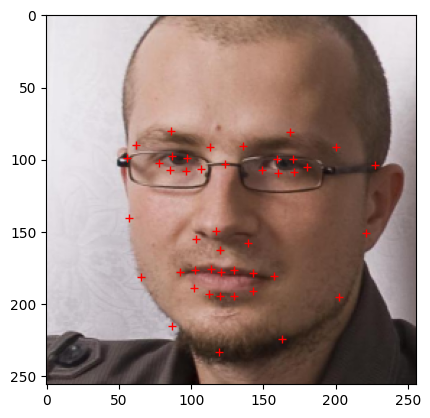

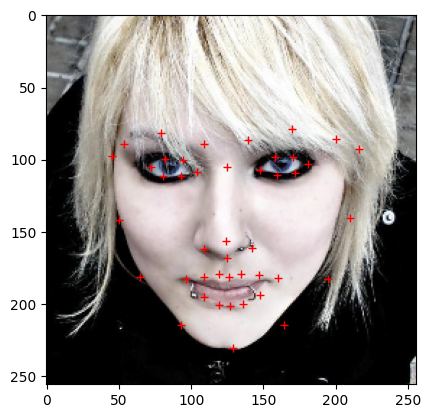

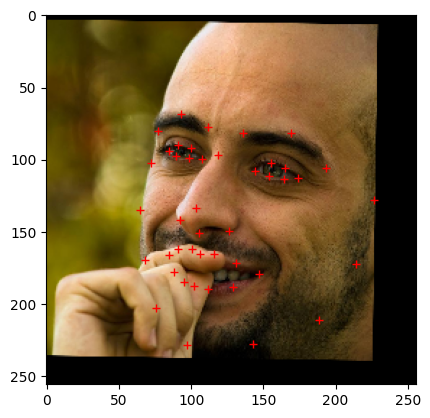

In [17]:
# Some examples on test images
for i in range(5):
  idx = np.random.randint(0, test_imgs.shape[0])
  test_img = test_imgs[idx].reshape(1,256,256)
  landmarks = sdm_predict(test_img, initial_landmarks, models)
  landmarks = landmarks.reshape(44,2)
  visualise_pts(test_images[idx], landmarks)

In [18]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [19]:
# Calculate the mean distance from all euclidean distances
# Designed to see performance from testing data with ground truth points

def get_mean_distance(images, true_pts, initial_landmarks, models):
  distances = []

  for i, pts in enumerate(true_pts):
    test_img = images[i].reshape(1,256,256)
    pred_pts = sdm_predict(test_img, initial_landmarks, models)
    pred_pts = pred_pts.reshape(44,2)
    distances.append(euclid_dist(pred_pts, pts))

  distances = np.array(distances)
  total_mean_distance = np.mean(distances[:])
  return total_mean_distance

In [20]:
initial_landmarks = np.mean(train_pts, axis=0)
initial_landmarks = initial_landmarks.reshape(1,44,2)

print(f"The mean distance is : {get_mean_distance(X_test, y_test, initial_landmarks, models)}")

The mean distance is : 5.216711537801414


# Second Task

In [21]:
def change_eye_lip_colour(image, initial_landmarks, models):
  """
  Change eyes and lips colour for red, green and blue.
  :param image: Image to change colours
  :param initial_landmarks: initial (mean) points needed for SDM prediction
  :param models: regression models generated my SDM
  """

  plt.figure(figsize=(15, 6))

  # Display original Image
  plt.subplot(1,5,1)
  plt.title('Original Image')
  plt.imshow(image)

  # Preprocess image for SDM prediction
  img_prep = preprocess_image(image)
  img_prep = img_prep.reshape(1,256,256)

  pts = sdm_predict(img_prep, initial_landmarks, models) # Predicted points
  pts = pts.reshape(44, 2)
  eye_left = np.array(pts[20:26, :], np.int32)  # Holds positions of points that are on left eye
  eye_right = np.array(pts[26:32, :], np.int32)  # Holds positions of points that are on right eye
  lips = np.array(pts[32:44, :], np.int32)  # Holds positions of points that are on the lips

  # Generate array of zeros of size Image
  binary_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

  # Create a binary mask of eyes and lips by
  # Filling all the space that is between points with 1 in binary Image
  cv2.fillPoly(binary_image, [eye_left], 1)
  cv2.fillPoly(binary_image, [eye_right], 1)
  cv2.fillPoly(binary_image, [lips], 1)

  mask = cv2.merge([binary_image]*3)  # Create a 3 channel mask

  # Apply the mask on the original image to cutout eyes and lips
  masked_image = cv2.multiply(image, mask)

  # Display the masked cutout image
  plt.subplot(1,5,2)
  plt.title('Mask cutout')
  plt.imshow(masked_image)

  # Create a boolean array of size Image
  # Where "True" are the values that positioned on eyes and lips
  mask_indices = binary_image > 0

  # Copy masked image for different colours
  mask_img_red = np.copy(masked_image)
  mask_img_green = np.copy(masked_image)
  mask_img_blue = np.copy(masked_image)

  # change colours of the masks in RGB
  mask_img_red[:,:,0][mask_indices] = 200
  mask_img_green[:,:,1][mask_indices] = 200
  mask_img_blue[:,:,2][mask_indices] = 200

  edited_image_red = np.copy(image)
  edited_image_green = np.copy(image)
  edited_image_blue = np.copy(image)

  # Apply coloured masks on the original image
  edited_image_red[mask_indices] = mask_img_red[mask_indices]
  edited_image_green[mask_indices] = mask_img_green[mask_indices]
  edited_image_blue[mask_indices] = mask_img_blue[mask_indices]

  plt.subplot(1,5,3)
  plt.title("Changed to Red")
  plt.imshow(edited_image_red)

  plt.subplot(1,5,4)
  plt.title("Changed to Green")
  plt.imshow(edited_image_green)

  plt.subplot(1,5,5)
  plt.title("Changed to Blue")
  plt.imshow(edited_image_blue)

  plt.show()


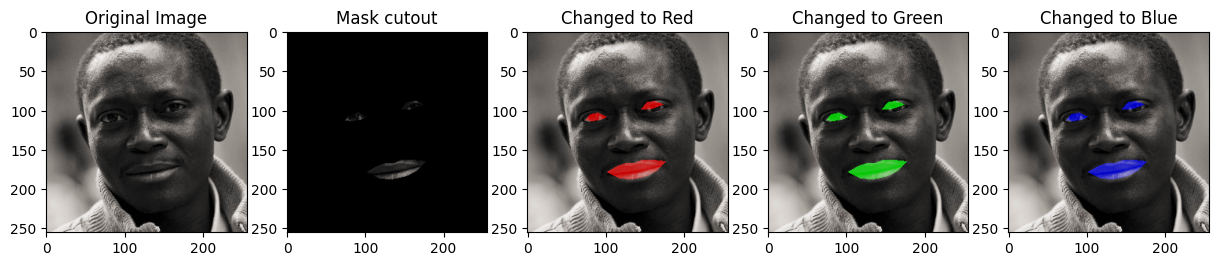

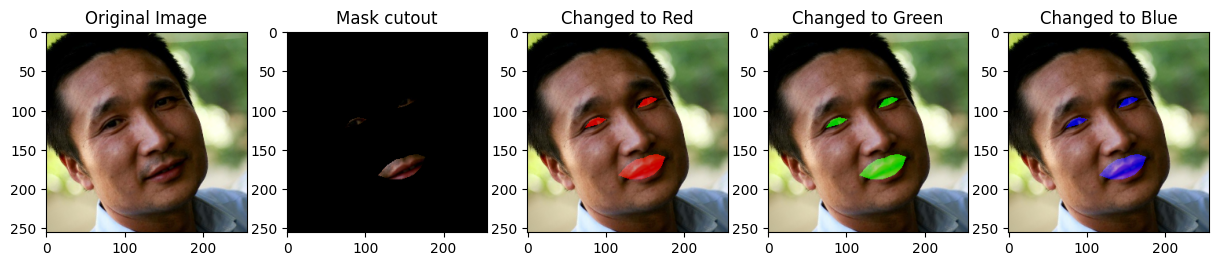

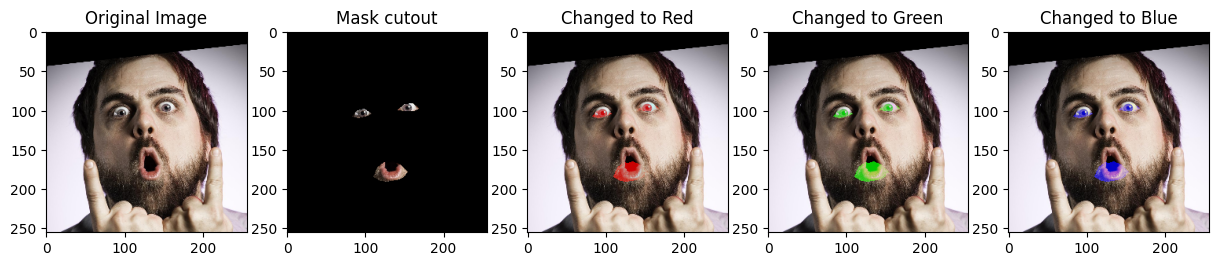

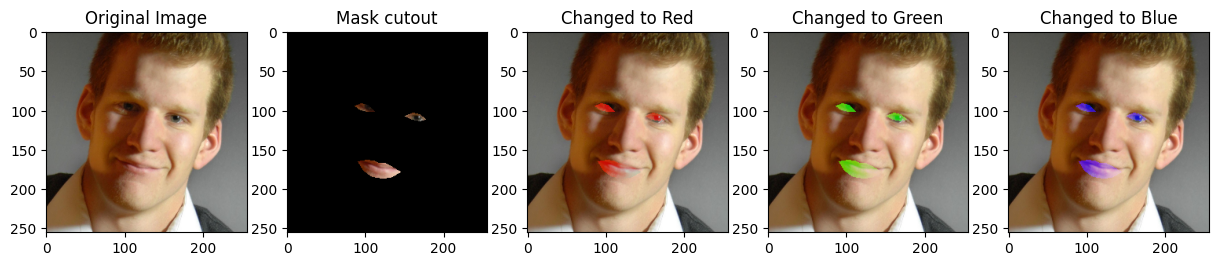

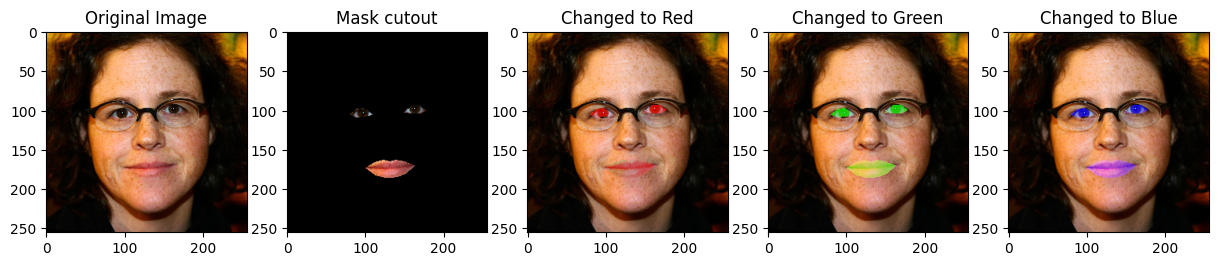

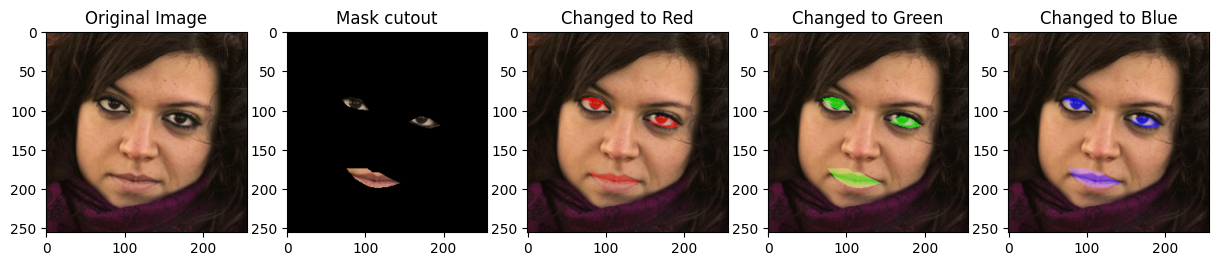

In [22]:
for i in range(len(example_images)):
  change_eye_lip_colour(example_images[i], initial_landmarks, models)

# Saving predicted points

In [23]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 50 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


In [24]:
predicted_points = []

# Extract predicted points from test images and add them to the list
for img in test_imgs:
  test_img = img.reshape(1,256,256)
  landmarks = sdm_predict(test_img, initial_landmarks, models)
  landmarks = landmarks.reshape(44,2)
  predicted_points.append(landmarks)

points = np.array(predicted_points)

# Save points
save_as_csv(points)

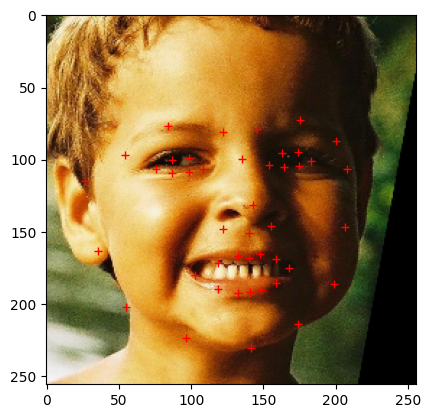

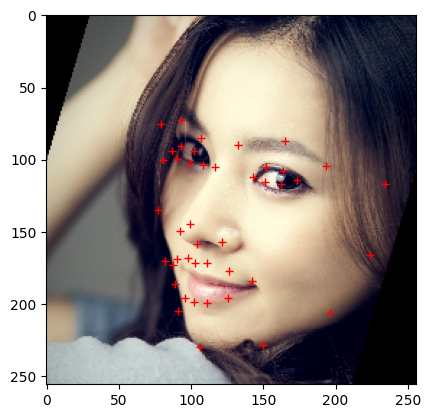

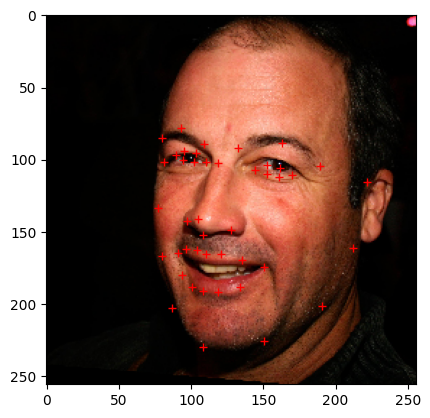

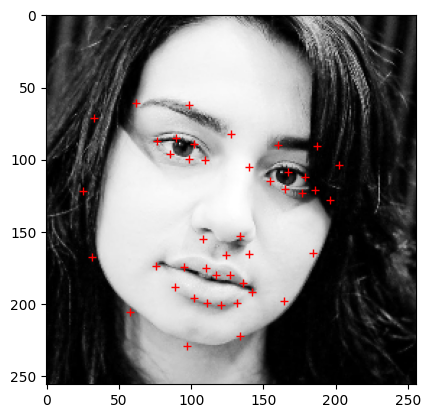

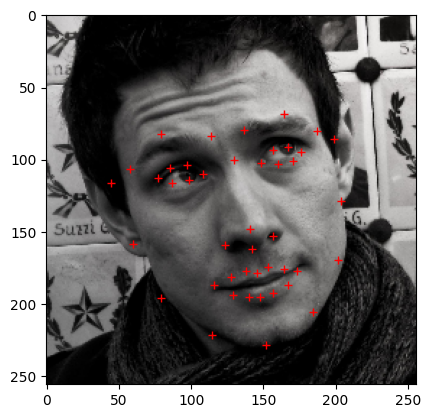

In [25]:
for i in range(5):
  visualise_pts(test_images[i], predicted_points[i])